# COVID-19 Government Policy Analysis

## Import required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.patches as patches
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib.gridspec as gridspec
import plotly.express as px
import plotly as plotly
from mpl_toolkits.mplot3d.axes3d import Axes3D
from pandas.plotting import register_matplotlib_converters
from celluloid import Camera
from IPython.display import HTML
from adjustText import adjust_text
from numpy.polynomial.polynomial import polyfit

## Load data

In [2]:
register_matplotlib_converters()
pd.options.mode.chained_assignment = None # default='warn'

# Load epidemiology csv
epi_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv", 
                       keep_default_na=False, na_values=[""], parse_dates=['date'], index_col=['date'])

# Load government response csv
gr_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/oxford-government-response.csv",
                      keep_default_na=False, na_values=[""], parse_dates=['date'], index_col=['date'])

# Load demographics csv
demo_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/demographics.csv", 
                       keep_default_na=False, na_values=[""])

# Load main csv for face covering data
data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/latest/main.csv",
                   keep_default_na=False, na_values=[""])
xls = pd.ExcelFile("https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/timeseries/OxCGRT_timeseries_all.xlsx")
fc_data = pd.read_excel(xls, 'h6_facial_coverings')

C:\Users\David\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## List of country and US state codes

In [3]:
# 3-letter region code required for extracting face covering policy data

country_code = [
['US','USA'],
['IL','ISR'],
['AT','AUT'],
['BE','BEL'],
['CZ','CZE'],
['DK','DNK'],
['FI','FIN'],
['FR','FRA'],
['GB','GBR'],
['DE','DEU'],
['IE','IRL'],
['IT','ITA'],
['NL','NLD'],
['PT','PRT'],
['ES','ESP'],
['SE','SWE'],
['NO','NOR'],
['CH','CHE'],
['IS','ISL'],
['TR','TUR'],
['SK','SVK'],
['HU','HUN'],
['BG','BGR']]

state_code = [
['US_AK','USA'],
['US_AL','USA'],
['US_AR','USA'],
['US_AZ','USA'],
['US_CA','USA'],
['US_CO','USA'],
['US_CT','USA'],
['US_DC','USA'],
['US_DE','USA'],
['US_FL','USA'],
['US_GA','USA'],
['US_HI','USA'],
['US_IA','USA'],
['US_ID','USA'],
['US_IL','USA'],
['US_IN','USA'],
['US_KS','USA'],
['US_KY','USA'],
['US_LA','USA'],
['US_MA','USA'],
['US_MD','USA'],
['US_ME','USA'],
['US_MI','USA'],
['US_MN','USA'],
['US_MO','USA'],
['US_MS','USA'],
['US_MT','USA'],
['US_NC','USA'],
['US_ND','USA'],
['US_NE','USA'],
['US_NH','USA'],
['US_NJ','USA'],
['US_NM','USA'],
['US_NV','USA'],
['US_NY','USA'],
['US_OH','USA'],
['US_OK','USA'],
['US_OR','USA'],
['US_PA','USA'],
['US_RI','USA'],
['US_SC','USA'],
['US_SD','USA'],
['US_TN','USA'],
['US_TX','USA'],
['US_UT','USA'],
['US_VA','USA'],
['US_VT','USA'],
['US_WA','USA'],
['US_WI','USA'],
['US_WV','USA'],
['US_WY','USA']]

## Data pre-processing functions

In [4]:
start_remove = ('2019-12-30')
end_remove = ('2019-12-31')
epi_data = epi_data.loc[(epi_data.index < start_remove) | (epi_data.index > end_remove)]

def preprocess_fc_data(data):
    '''Re-indexes face covering data'''
    data.columns = ['face_covering']
    data.index.name = 'date'
    data.index = pd.to_datetime(data.index)
    return data

def preprocess_data(epi_data, gr_data, fc_data, demo_data, code1, code2):
    '''Loads data from csv files and returns country-specific variables'''
    epi_df = epi_data[(epi_data.key) == code1] # load epidemiology data into country-specific dataframe
    epi_df['rolling_cases'] = epi_df['new_confirmed'].rolling(7).mean() # add rolling 7-day average cases column
    gr_df = gr_data[(gr_data.key) == code1] # load government response data into country-specific dataframe
    fc_df = fc_data[(fc_data.country_code) == code2].drop(columns=['country_code', 'country_name']).T 
    try:
        fc_df = preprocess_fc_data(fc_df) # re-index face covering data in country-specific dataframe
    except:
        print(code1)
    demo_df = demo_data[(demo_data.key == code1)] # load demographic data into country-specific dataframe
    return epi_df, gr_df, fc_df, demo_df

## Pre-process data for regions listed above

In [5]:
# iterate through list of US States to separate data into state-specific dataframes
for i in range(len(state_code)):
    cc1 = state_code[i][0]
    cc2 = state_code[i][1]
    globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], globals()["{0}_fc_df".format(cc1)], \
    globals()["{0}_demo_df".format(cc1)] = preprocess_data(epi_data, gr_data, fc_data, demo_data, cc1, cc2)
    
# iterate through list of countries to separate data into country-specific dataframes
for i in range(len(country_code)):
    cc1 = country_code[i][0]
    cc2 = country_code[i][1]
    globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], globals()["{0}_fc_df".format(cc1)], \
    globals()["{0}_demo_df".format(cc1)] = preprocess_data(epi_data, gr_data, fc_data, demo_data, cc1, cc2)

In [6]:
def calculate_average_containment_index(epi_data, gr_data, demo_data, country):
    '''Normalizes containment policies over the length of the dataset and returns an average containment index'''
    C1 = gr_data['school_closing']/3 # each policy is normalized between 0 and 1
    C2 = gr_data['workplace_closing']/3
    C3 = gr_data['cancel_public_events']/2
    C4 = gr_data['restrictions_on_gatherings']/4
    C5 = gr_data['public_transport_closing']/2
    C6 = gr_data['stay_at_home_requirements']/3
    C7 = gr_data['restrictions_on_internal_movement']/2
    C8 = gr_data['international_travel_controls']/4
    gr_data['contain_policy_avg'] = ((C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8) / 8 ) * 100
    gr_data['containment_idx'] = gr_data['contain_policy_avg'].sum()/len(gr_data)
    return pd.to_numeric(gr_data['containment_idx'].values[0]) 

In [7]:
def plot_state_by_index(epi_data, demo_data, country, ax0, ax, i, state_list, zlim):
    '''Produces 3D plot of US cases per capita'''
    start_remove = ('2019-12-30')
    end_remove = ('2020-2-29')
    epi_data = epi_data.loc[(epi_data.index < start_remove) | (epi_data.index > end_remove)]
    case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000
    p = ax0.fill_between(epi_data.index.values, case_rate_100K)
    path = p.get_paths()[0]
    pp = patches.PathPatch(path, alpha=0.15)
    ax.add_patch(pp)
    art3d.pathpatch_2d_to_3d(pp,z=i,zdir='y')
    ax.set_xlim3d([dt.date(2020, 3, 1), dt.date(2020, 12, 1)])
    ax.set_ylim3d(0, i)
    ax.set_zlim3d(0, zlim)
    ax.grid(False)
    # rename x axis ticklabels to months
    months = {"Jan":0, "Feb":1, "Mar":2, "Apr":3, "May":4, "Jun":5, "Jul":6, 
              "Aug":7, "Sep":8, "Oct":9, "Nov":10, "Dec":11 } # desired format
    month_idx = np.unique(epi_data.index.month_name()).tolist() # extract month names
    month_idx = [month[0:3] for month in month_idx] # take first 3 letters of month
    month_idx = sorted(month_idx, key=months.get) # sort months according to dict
    ax.set_xticklabels(month_idx, fontsize=11)
    ax.yaxis._axinfo['juggled'] = (1,1,0)
    ax.set_yticks(np.arange(1,len(state_list)+1))
    ax.set_yticklabels(state_list, 
                verticalalignment='baseline',
                horizontalalignment='right',
                fontsize=9)
    ax.set_zticks([])
    ax.w_zaxis.line.set_lw(0.)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    return

## Plot US states cases per capita and sort by containment index

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  del sys.path[0]


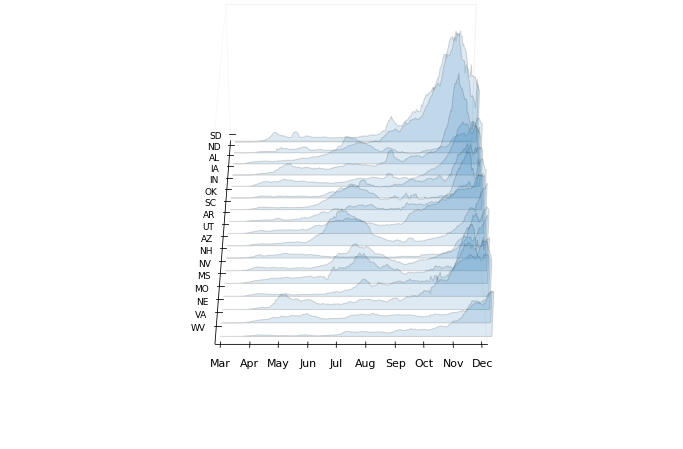

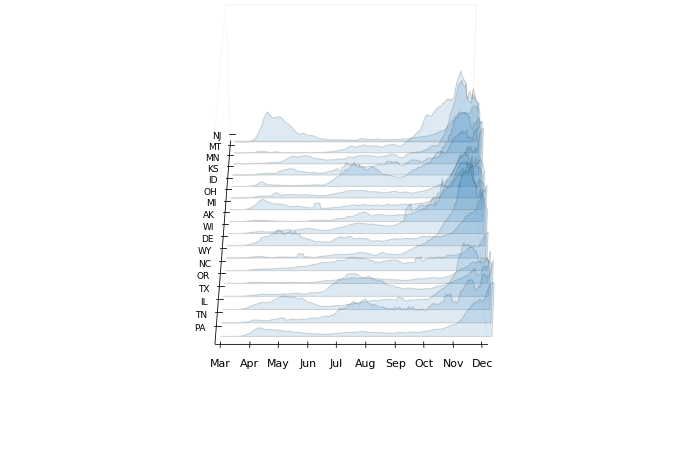

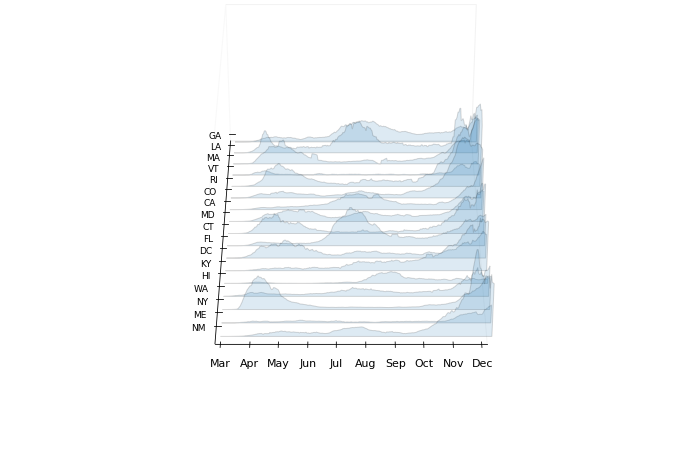

In [8]:
# calculate average containment index for all states
state_ci = []
for i in range(len(state_code)):
    cc1 = state_code[i][0]
    tmp = calculate_average_containment_index(globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], 
                          globals()["{0}_demo_df".format(cc1)], cc1)
    state_ci.append([cc1, tmp])

# sort states by index
state_ci.sort(key = lambda x: x[1], reverse=True)
ci_thresholds = [0, 48.5, 52.7, 100] # thresholds determine where to start new plot

for x in range(3):
    # parameters for 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax0 = plt.figure().gca()
    ax = fig.gca(projection='3d')
    ax.elev = 35
    ax.azim = 270
    ax.dist = 14
    x_scale = 1
    y_scale = 2.1
    z_scale = 1
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([x_scale, y_scale, z_scale, 1]))

    j = 0 
    state_list = []
    # generate list of states for each plot based on index thresholds
    for i in range(len(state_code)):
        state = state_ci[i][0]
        if state_ci[i][1] < ci_thresholds[x+1] and state_ci[i][1] >= ci_thresholds[x]:
            state_list.append(state[3:])
    # plot states on above list
    for i in range(len(state_code)):
        state = state_ci[i][0]
        if state_ci[i][1] < ci_thresholds[x+1] and state_ci[i][1] >= ci_thresholds[x]:
            plot_state_by_index(globals()["{0}_epi_df".format(state)], globals()["{0}_demo_df".format(state)], 
                                state, ax0, ax, j, state_list, zlim=200)
            j += 1
    plt.close()
    plt.savefig("testing_{0}".format(x), dpi=300)

## Scatterplot of US states by containment index and cases per capita

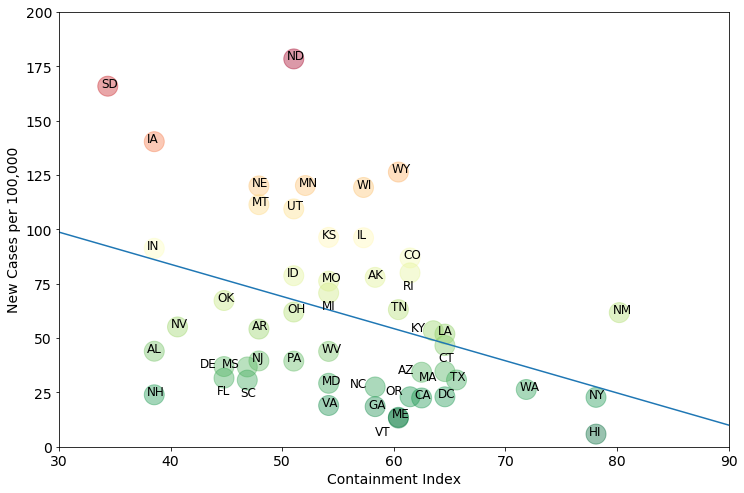

In [9]:
# generate list of states with containment index and case rate per capita for dates below
case_rate_v_containment = []
date1 = '2020-11-1'
date2 = '2020-11-16'
for i in range(len(state_code)):
    cc1 = state_code[i][0]
    try:
        date_si = globals()["{0}_gr_df".format(cc1)][pd.Timestamp(date1):pd.Timestamp(date1)]['contain_policy_avg'].values[0]
    except:
        print(cc1)
    try:
        case_rate_100K = globals()["{0}_epi_df".format(cc1)]['rolling_cases']/globals()["{0}_demo_df".format(cc1)]['population'].values[0]*100000
    except:
        print(cc1)
    date_cr = case_rate_100K[pd.Timestamp(date2):pd.Timestamp(date2)].values[0]
    case_rate_v_containment.append([cc1, date_si, date_cr])

# sort list by containment index
case_rate_v_containment.sort(key = lambda x: x[1], reverse=True)
case_rate_v_containment = np.array(case_rate_v_containment)
plt.figure(figsize=(12,8))
label = case_rate_v_containment[:,0]
label = [state[3:] for state in label] # extract state abbreviation
x = case_rate_v_containment[:,1].astype(float)
y = case_rate_v_containment[:,2].astype(float)
plt.scatter(x, y, s=400, c=y, cmap='RdYlGn_r', alpha=0.4)
plt.xlim((30, 90))
plt.ylim((0, 200))
plt.xlabel('Containment Index', fontsize=14)
plt.ylabel('New Cases per 100,000', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
line_x = range(0,101)
b, m = polyfit(x, y, 1) # line of best fit
plt.plot(line_x, b + m * line_x, '-', linewidth=1.5)
texts = []
for i, txt in enumerate(label):
    texts.append(plt.text(x[i]-0.65, y[i]-2.25, txt, fontsize=12))
adjust_text(texts)
# plt.savefig('US_scatter', dpi=300)
plt.show()

## Animation of European countries cases per capita and containment index over time

In [10]:
# calculate average containment index for all countries in list
for i in range(len(country_code)):
    cc1 = country_code[i][0]
    tmp = calculate_average_containment_index(globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], 
                          globals()["{0}_demo_df".format(cc1)], cc1)
    
region_code = country_code
fig = plt.figure(figsize=(12, 8))
camera = Camera(fig)
# loop through 100 days
for j in range(250,350):
    skip = False
    case_rate_v_containment = []
    for i in range(len(region_code)):
        cc1 = region_code[i][0]
        # if any country is missing data, skip to next day
        try:
            date_si = globals()["{0}_gr_df".format(cc1)]['contain_policy_avg'].values[j]
            if np.isnan(date_si) == True:
                skip = True
        except:
            skip = True
        try:
            case_rate_100K = globals()["{0}_epi_df".format(cc1)]['rolling_cases']/globals()["{0}_demo_df".format(cc1)]['population'].values[0]*100000
        except:
            skip = True
        try:
            date_cr = case_rate_100K.values[j]
        except:
            skip = True
        if skip == True:
            break
        case_rate_v_containment.append([cc1, date_si, date_cr])
    if skip == True:
        continue
    case_rate_v_containment.sort(key = lambda x: x[1], reverse=True)
    case_rate_v_containment = np.array(case_rate_v_containment)
    label = case_rate_v_containment[:,0]
    x = case_rate_v_containment[:,1].astype(float)
    y = case_rate_v_containment[:,2].astype(float)
    norm = plt.Normalize(vmin=0, vmax=90) # normalize for consistent colour gradient
    plt.scatter(x, y, s=300, c=y, norm=norm, cmap='RdYlGn_r', alpha=0.4)
    plt.xlim((0, 100))
    plt.ylim((0, 175)) 
    plt.xlabel('Containment Index', fontsize=14)
    plt.ylabel('New Cases per 100,000', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    text = globals()["{0}_gr_df".format(cc1)].index[j].strftime("%d-%b-%Y")
    plt.text(50, 165, text, horizontalalignment='center', verticalalignment='center', fontsize=18)
    for i, txt in enumerate(label):
        plt.annotate(txt, (x[i]-1, y[i]-2), fontsize=12)
    camera.snap()
anim = camera.animate()
plt.close()
HTML(anim.to_html5_video())

## Plot country-specific containment index, policy levels, and cases per capita 

In [11]:
def plot_containment_index(epi_data, gr_data, demo_data, country):
    '''Plots a specified country's containment policies and index over time'''
    case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000 # cases per 100K people
    months = {"Jan":0, "Feb":1, "Mar":2, "Apr":3, "May":4, "Jun":5, "Jul":6, 
              "Aug":7, "Sep":8, "Oct":9, "Nov":10, "Dec":11 }
    month_idx = np.unique(epi_data.index.month_name()).tolist()
    month_idx = [month[0:3] for month in month_idx]
    month_idx = sorted(month_idx, key=months.get)
    gs = gridspec.GridSpec(9,1, height_ratios=[4,1,1,1,1,1,1,1,1]) # height ratio for each subplot
    fig = plt.figure(figsize=(15, 7))

    ax = fig.add_subplot(gs[0]) 
    ax.set(ylabel='Containment Index')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.fill_between(gr_data.index.values,
                     gr_data['contain_policy_avg'],
                     label='containment index',
                     color='red',
                     alpha=0.25)
    ax.set_ylim([0,100])
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(False)

    ax2 = ax.twinx()
    ax2.bar(epi_data.index.values,
            case_rate_100K,
            color='blue',
            label='new cases per 100,000',
            alpha=0.5)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax2.set(ylabel='New Cases per 100,000',
           title=country + ' Containment Policies')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.set_ylim([0, case_rate_100K.max()])
    ticks = [tick for tick in plt.gca().get_yticks() if tick >= 0]
    plt.gca().set_yticks(ticks)
    x_axis = ax2.axes.get_xaxis()
    x_axis.set_visible(False)
    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)
    leg = plt.legend(handles,labels, loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax3 = fig.add_subplot(gs[1], sharex=ax)
    ax3.fill_between(gr_data.index.values, 
                     gr_data['school_closing']/3,
                     label='school closures',
                     color='green',
                     alpha=0.25)
    ax3.set_ylim([0,1])
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.set_yticks([])
    x_axis = ax3.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax4 = fig.add_subplot(gs[2], sharex=ax)
    ax4.fill_between(gr_data.index.values,
                     gr_data['workplace_closing']/3, # each policy is normalized between 0 and 1
                     label='workplace closures',
                     color='darkorange',
                     alpha=0.25)
    ax4.set_ylim([0,1])
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax4.set_yticks([])
    x_axis = ax4.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax5 = fig.add_subplot(gs[3], sharex=ax)
    ax5.fill_between(gr_data.index.values,
                     gr_data['cancel_public_events']/2,
                     label='public event cancellations',
                     color='magenta',
                     alpha=0.25)
    ax5.set_ylim([0,1])
    ax5.spines['right'].set_visible(False)
    ax5.spines['top'].set_visible(False)
    ax5.spines['left'].set_visible(False)
    ax5.set_yticks([])
    x_axis = ax5.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax6 = fig.add_subplot(gs[4], sharex=ax)
    ax6.fill_between(gr_data.index.values,
                     gr_data['restrictions_on_gatherings']/4,
                     label='gathering restrictions',
                     color='gold',
                     alpha=0.25)
    ax6.set_ylim([0,1])
    ax6.spines['right'].set_visible(False)
    ax6.spines['top'].set_visible(False)
    ax6.spines['left'].set_visible(False)
    ax6.set_yticks([])
    x_axis = ax6.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax7 = fig.add_subplot(gs[5], sharex=ax)
    ax7.fill_between(gr_data.index.values,
                     gr_data['public_transport_closing']/2,
                     label='public transport closures',
                     color='blue',
                     alpha=0.25)
    ax7.set_ylim([0,1])
    ax7.spines['right'].set_visible(False)
    ax7.spines['top'].set_visible(False)
    ax7.spines['left'].set_visible(False)
    ax7.set_yticks([])
    x_axis = ax7.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax8 = fig.add_subplot(gs[6], sharex=ax)
    ax8.fill_between(gr_data.index.values,
                     gr_data['stay_at_home_requirements']/3,
                     label='stay at home requirements',
                     color='darkred',
                     alpha=0.25)
    ax8.set_ylim([0,1])
    ax8.spines['right'].set_visible(False)
    ax8.spines['top'].set_visible(False)
    ax8.spines['left'].set_visible(False)
    ax8.set_yticks([])
    x_axis = ax8.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax9 = fig.add_subplot(gs[7], sharex=ax)
    ax9.fill_between(gr_data.index.values,
                     gr_data['restrictions_on_internal_movement']/2,
                     label='internal border controls',
                     color='deepskyblue',
                     alpha=0.25)
    ax9.set_ylim([0,1])
    ax9.spines['right'].set_visible(False)
    ax9.spines['top'].set_visible(False)
    ax9.spines['left'].set_visible(False)
    ax9.set_yticks([])
    x_axis = ax9.axes.get_xaxis()
    x_axis.set_visible(False)
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    
    ax10 = fig.add_subplot(gs[8], sharex=ax)
    ax10.fill_between(gr_data.index.values,
                     gr_data['international_travel_controls']/4,
                     label='international border controls',
                     color='indigo',
                     alpha=0.25)
    ax10.set_ylim([0,1])
    ax10.spines['right'].set_visible(False)
    ax10.spines['top'].set_visible(False)
    ax10.spines['left'].set_visible(False)
    ax10.set_yticks([])
    leg = plt.legend(loc='upper left')
    leg.get_frame().set_linewidth(0.0)  
    ax10.set_xticklabels(month_idx, fontsize=10)
    
    ax10.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
    fig.tight_layout()
    plt.show()
    plt.close()

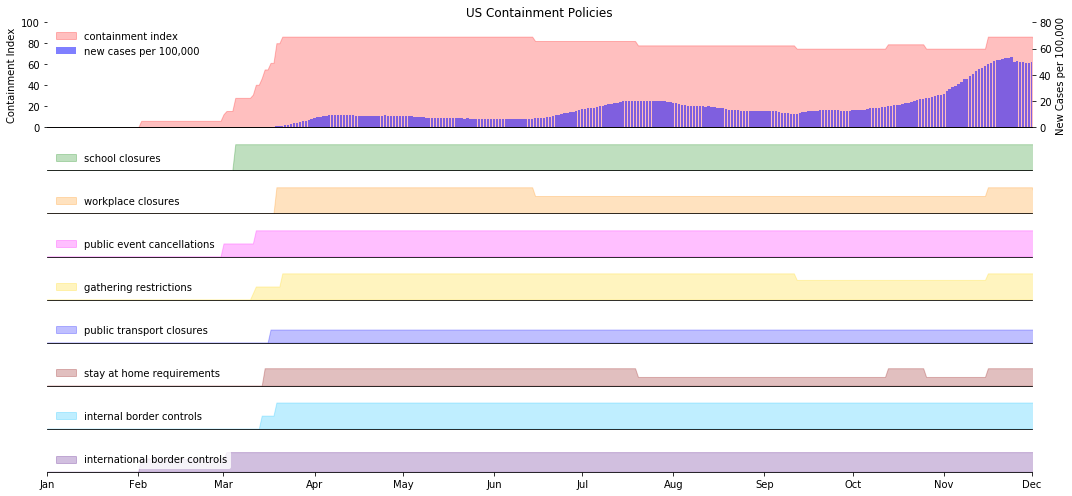

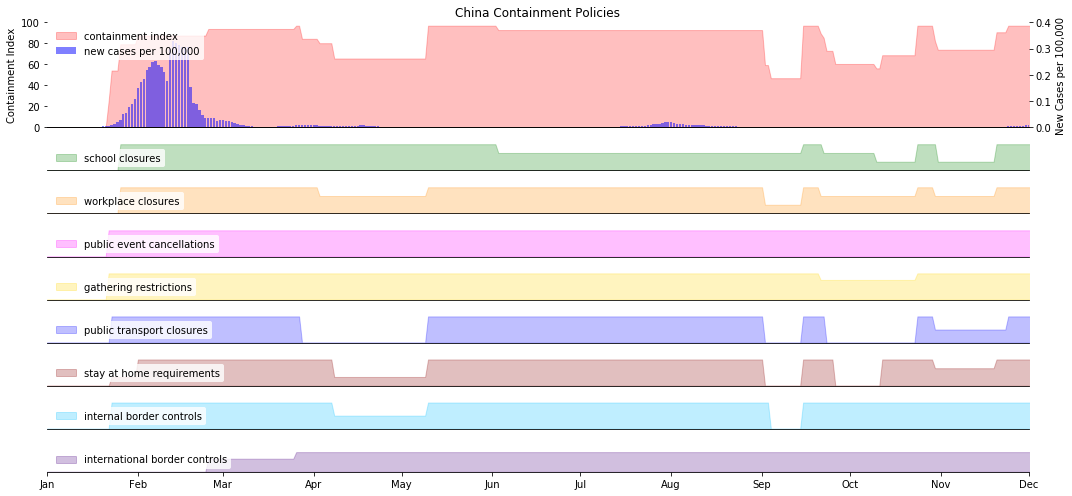

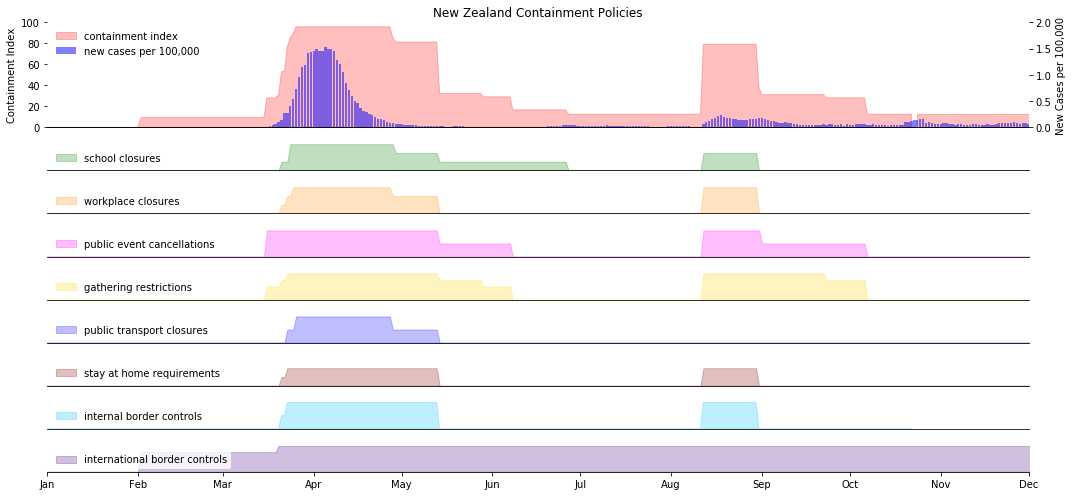

In [12]:
country_code = [
['US','USA'],
['NZ','NZL'],
['CN','CHN']]

# extract data for above countries into country-specific dataframes
for i in range(len(country_code)):
    cc1 = country_code[i][0]
    cc2 = country_code[i][1]
    globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], globals()["{0}_fc_df".format(cc1)], \
    globals()["{0}_demo_df".format(cc1)] = preprocess_data(epi_data, gr_data, fc_data, demo_data, cc1, cc2)
    calculate_average_containment_index(globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], 
                          globals()["{0}_demo_df".format(cc1)], cc1)
    
plot_containment_index(US_epi_df, US_gr_df, US_demo_df, 'US')
plot_containment_index(CN_epi_df, CN_gr_df, CN_demo_df, 'China')
plot_containment_index(NZ_epi_df, NZ_gr_df, NZ_demo_df, 'New Zealand')

## Plot second wave for European countries

In [13]:
def plot_epi(epi_data_1,epi_data_2,epi_data_3,epi_data_4,epi_data_5,epi_data_6, country):
    '''Plots cases per country for up to 6 countries'''
    fig = plt.figure(1, figsize=(15, 7))
    ax = fig.add_subplot(111)
    ax.set(xlabel='Month',
           ylabel='New Daily Cases',
           title=country)

    ax.plot(epi_data_1.index.values,
            epi_data_1['rolling_cases'],
            color='olive',
            label='Bulgaria')
    
    ax2 = ax.twinx()
    ax2.plot(epi_data_2.index.values,
            epi_data_2['rolling_cases'],
            color='pink',
            label='Hungary')
    ax2.set_yticks([]) 
    
    ax3 = ax.twinx()
    ax3.plot(epi_data_3.index.values,
            epi_data_3['rolling_cases'],
            color='khaki',
            label='Slovenia')
    ax3.set_yticks([]) 
    
    ax4 = ax.twinx()
    ax4.plot(epi_data_4.index.values,
            epi_data_4['rolling_cases'],
            color='red',
            label='Italy')
    ax4.set_yticks([]) 
    
    ax5 = ax.twinx()
    ax5.plot(epi_data_5.index.values,
            epi_data_5['rolling_cases'],
            color='lightblue',
            label='Finland')
    ax5.set_yticks([]) 
    
    ax6 = ax.twinx()
    ax6.plot(epi_data_6.index.values,
            epi_data_6['rolling_cases'],
            color='gold',
            label='Ireland')
    ax6.set_yticks([]) 
    
    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    ax.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
    plt.legend(handles,labels)
    plt.show()
    plt.close()

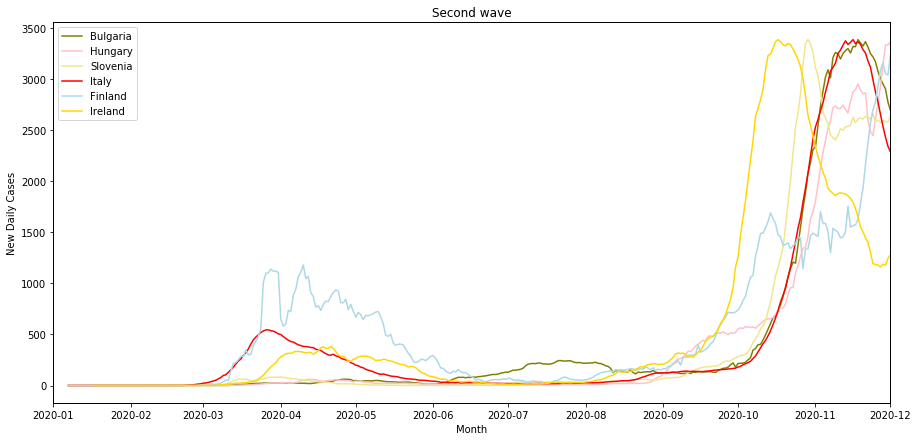

In [14]:
country_code = [
['BG','BGR'],
['HU','HUN'],
['SI','SVN'],
['IT','ITA'],
['FI','FIN'],
['GB_NIR','GBR']]

# extract data for above countries into country-specific dataframes
for i in range(len(country_code)):
    cc1 = country_code[i][0]
    cc2 = country_code[i][1]
    globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], globals()["{0}_fc_df".format(cc1)], \
    globals()["{0}_demo_df".format(cc1)] = preprocess_data(epi_data, gr_data, fc_data, demo_data, cc1, cc2)
    calculate_average_containment_index(globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], 
                          globals()["{0}_demo_df".format(cc1)], cc1)

plot_epi(BG_epi_df,HU_epi_df,SI_epi_df,IT_epi_df,FI_epi_df,GB_NIR_epi_df,'Second wave')

## Plot country-specific cases and change in policy levels

In [15]:
def spike_plot_containment_policies(epi_data, gr_data, country):
    '''Plots a specified country's change containment policy levels over time'''
    fig = plt.figure(1, figsize=(15, 7))
    ax = fig.add_subplot(111)
    ax.set(xlabel='Month',
           ylabel='New Daily Cases',
           title=country + ' Containment Policies vs Cases')

    ax.plot(epi_data.index.values,
            epi_data['rolling_cases'],
            color='blue',
            label='New Daily Cases (7-day avg)')

    ax2 = ax.twinx()
    ax2.plot(gr_data.index.values,
            gr_data['stay_at_home_requirements'].diff(), # .diff plots change in value
            color='red',
            label='Stay at Home [0-3]]')

    ax2.plot(gr_data.index.values,
            gr_data['workplace_closing'].diff(),
            color='orange',
            label='Workplace Closing [0-3]')

    ax2.plot(gr_data.index.values,
            gr_data['school_closing'].diff(),
            color='purple',
            label='School Closing [0-3]')

    
    ax2.plot(gr_data.index.values,
            gr_data['restrictions_on_gatherings'].diff(),
            color='lightblue',
            label='Gather Restrictions [0-4]')
    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    ax.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
    plt.legend(handles,labels)
    plt.show()
    plt.close()

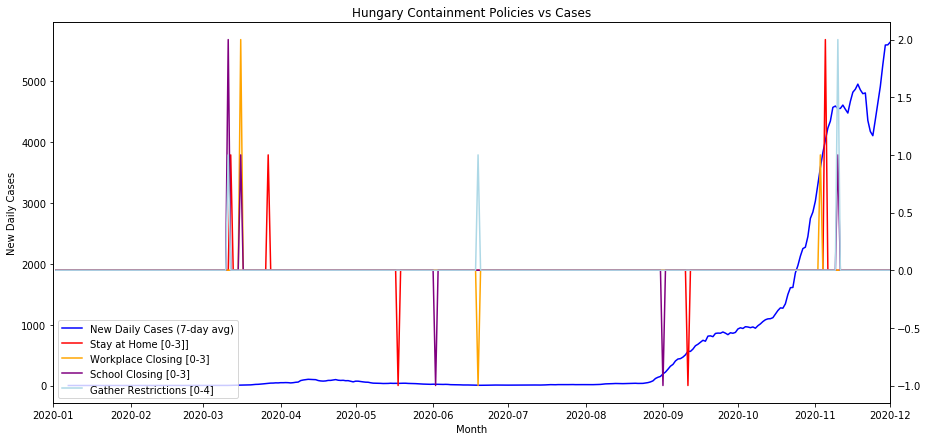

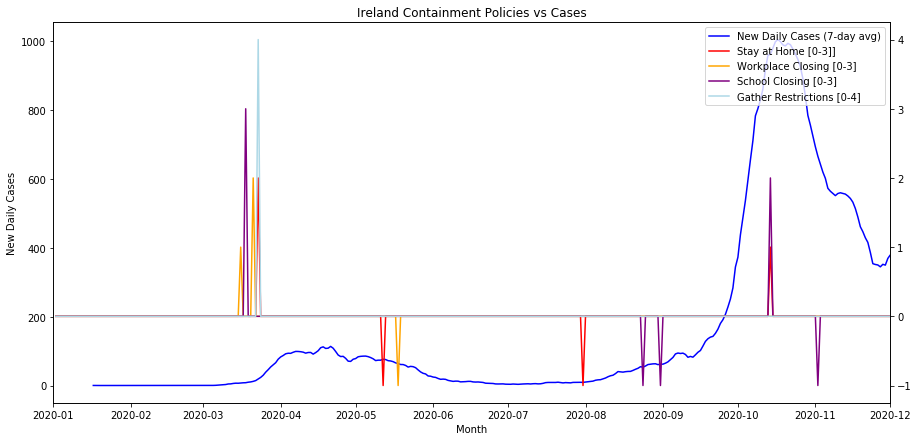

In [16]:
spike_plot_containment_policies(HU_epi_df, HU_gr_df, 'Hungary')
spike_plot_containment_policies(GB_NIR_epi_df, GB_NIR_gr_df, 'Ireland')

# World Maps

#### Get Country Level Data from Main dataset

In [17]:
# Get data from entire countries only (no sub country entities such as states)
countries = data[data.aggregation_level == 0]

# We no longer need the subregion-level columns
countries = countries.drop(columns=['subregion1_code', 'subregion1_name', 'subregion2_code', 'subregion2_name'])
countries = countries[['country_code', 'country_name', 'stringency_index']]
countries = countries.reset_index()

# Change the 'country_code' name to 'key' as it is in our other datasets
countries = countries.rename(columns={'country_code' : 'key'})
countries = countries.drop(columns=['index'])

# EPI Start
# Epi data for plotting cases
epi_case_data = epi_data[['key','total_confirmed']]

# Setup the dataframe so that all countries are organized with their case rates
epi_case_data = epi_case_data[epi_case_data['key'].apply(lambda x: len(x) < 3)]
epi_case_data = epi_case_data.groupby(['key']).max()
epi_case_and_countries = epi_case_data.merge(countries, left_on='key', right_on='key')
# EPI End


# Containment Map Start
# Get containment policies for all countries
all_containment_policies = gr_data[['key']]

# Normalize the policies 
C1 = gr_data['school_closing']/3
C2 = gr_data['workplace_closing']/3
C3 = gr_data['cancel_public_events']/2
C4 = gr_data['restrictions_on_gatherings']/4
C5 = gr_data['public_transport_closing']/2
C6 = gr_data['stay_at_home_requirements']/3
C7 = gr_data['restrictions_on_internal_movement']/2
C8 = gr_data['international_travel_controls']/4

all_containment_policies['contain_policy_avg'] = ((C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8))/8
all_containment_policies_sum = all_containment_policies.groupby(['key']).sum()
all_containment_policies_sum = (all_containment_policies_sum / all_containment_policies_sum.max()) * 100

gr_containment_policies_countries = all_containment_policies_sum.merge(countries, left_on='key', right_on='key')
# Containment Map End


# Health Policy Map Start
all_health_policies = gr_data[['key']]

# Get specific health policies
C1 = gr_data['testing_policy']/3
C2 = gr_data['contact_tracing']/2
C3 = gr_data['public_information_campaigns']/2

all_health_policies['health_policy_avg'] = (C1 + C2 + C3)/3 
all_health_policies_sum = all_health_policies.groupby(['key']).sum()
all_health_policies_sum = (all_health_policies_sum / all_health_policies_sum.max()) * 100

gr_health_policies_countries = all_health_policies_sum.merge(countries, left_on='key', right_on='key')
# Health Policy Map End

## Containment + Health Index World Map

In [18]:
# Use plotly to plot the index for each country
fig = px.choropleth(countries, locations="country_name",
                    color=(countries["stringency_index"]), 
                    hover_name="country_name", 
                    hover_data=["stringency_index"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Containment + Health Index World Map")
fig.update_coloraxes(colorbar_title="Containment + Health Index Scale",colorscale="Blues")
fig.show()

## Confirmed Cases World Map

In [19]:
# Plot number of confirmed cases per country
fig = px.choropleth(epi_case_and_countries, locations="country_name",
                    color=np.log10(epi_case_and_countries["total_confirmed"]), 
                    hover_name="country_name", 
                    hover_data=["total_confirmed"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Confirmed Cases")
fig.update_coloraxes(colorbar_title="Confirmed Cases(Log Scale)",colorscale="Reds")
fig.show()

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log10



## Containment Policies Index World Map

In [20]:
# Plot the containment index
fig = px.choropleth(gr_containment_policies_countries, locations="country_name",
                    color=(gr_containment_policies_countries["contain_policy_avg"]),
                    hover_name="country_name", 
                    hover_data=["contain_policy_avg"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Containment Policy Index")
fig.update_coloraxes(colorbar_title="Containment Policy Index",colorscale="Oranges")
fig.show()

## Health Policies Index World Map

In [21]:
# Plot the Health Policies Index for each country
fig = px.choropleth(gr_health_policies_countries, locations="country_name",
                    color=(gr_health_policies_countries["health_policy_avg"]),
                    hover_name="country_name", 
                    hover_data=["health_policy_avg"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Health Policy Index")
fig.update_coloraxes(colorbar_title="Health Policy Index",colorscale="Greens")
fig.show()

## Cases Each Month World Map

In [22]:
# Working dataframe for the epidimiology data
df = epi_data
df = df[df['key'].apply(lambda x: len(x) < 3)]

# Drop uncessary columns
df = df.drop(columns=['total_confirmed','new_deceased','new_recovered','new_tested','total_deceased', 'total_recovered', 'total_tested'])

# Data for each month
jan_start = '2020-1-1'
jan_end = '2020-1-31'
jan_df = df[jan_start:jan_end]
jan_df = jan_df.groupby(['key']).max()

feb_start = '2020-2-1'
feb_end = '2020-2-29'
feb_df = df[feb_start:feb_end]
feb_df = feb_df.groupby(['key']).max()

mar_start = '2020-3-1'
mar_end = '2020-3-31'
mar_df = df[mar_start:mar_end]
mar_df = mar_df.groupby(['key']).max()

apr_start = '2020-4-1'
apr_end = '2020-4-30'
apr_df = df[apr_start:apr_end]
apr_df = apr_df.groupby(['key']).max()

may_start = '2020-5-1'
may_end = '2020-5-31'
may_df = df[may_start:may_end]
may_df = may_df.groupby(['key']).max()

jun_start = '2020-6-1'
jun_end = '2020-6-30'
jun_df = df[jun_start:jun_end]
jun_df = jun_df.groupby(['key']).max()

jul_start = '2020-7-1'
jul_end = '2020-7-31'
jul_df = df[jul_start:jul_end]
jul_df = jul_df.groupby(['key']).max()

aug_start = '2020-8-1'
aug_end = '2020-8-31'
aug_df = df[aug_start:aug_end]
aug_df = aug_df.groupby(['key']).max()

sep_start = '2020-9-1'
sep_end = '2020-9-30'
sep_df = df[sep_start:sep_end]
sep_df = sep_df.groupby(['key']).max()

oct_start = '2020-10-1'
oct_end = '2020-10-31'
oct_df = df[oct_start:oct_end]
oct_df = oct_df.groupby(['key']).max()

nov_start = '2020-11-1'
nov_end = '2020-11-30'
nov_df = df[nov_start:nov_end]
nov_df = nov_df.groupby(['key']).max()


dec_start = '2020-12-1'
dec_end = '2020-12-31'
dec_df = df[dec_start:dec_end]
dec_df = dec_df.groupby(['key']).max()

# Merge monthly data with countries
jan_and_countries = jan_df.merge(countries, left_on='key', right_on='key')
feb_and_countries = feb_df.merge(countries, left_on='key', right_on='key')
mar_and_countries = mar_df.merge(countries, left_on='key', right_on='key')
apr_and_countries = apr_df.merge(countries, left_on='key', right_on='key')
may_and_countries = may_df.merge(countries, left_on='key', right_on='key')
jun_and_countries = jun_df.merge(countries, left_on='key', right_on='key')
jul_and_countries = jul_df.merge(countries, left_on='key', right_on='key')
aug_and_countries = aug_df.merge(countries, left_on='key', right_on='key')
sep_and_countries = sep_df.merge(countries, left_on='key', right_on='key')
oct_and_countries = oct_df.merge(countries, left_on='key', right_on='key')
nov_and_countries = nov_df.merge(countries, left_on='key', right_on='key')
dec_and_countries = dec_df.merge(countries, left_on='key', right_on='key')

In [23]:
import warnings
warnings.filterwarnings("ignore")

# Prep data for the animated slider
data_slider = []
steps = []

jan_month = dict(
                    type='choropleth',
                    locations = jan_and_countries['country_name'],
                    z=np.log10(jan_and_countries['new_confirmed']),
                    locationmode="country names",
                    colorscale = 'Reds',
                    colorbar = {'title': 'Monthly Mean (Log)'},
                    )

feb_month = dict(
                    type='choropleth',
                    locations = feb_and_countries['country_name'],
                    z=np.log10(feb_and_countries['new_confirmed']),
                    locationmode="country names",
                    colorscale = 'Reds',
                    colorbar = {'title': 'Monthly Mean (Log)'},
                    )

mar_month = dict(
                    type='choropleth',
                    locations = mar_and_countries['country_name'],
                    z=np.log10(mar_and_countries['new_confirmed']),
                    locationmode="country names",
                    colorscale = 'Reds',
                    colorbar = {'title': 'Monthly Mean (Log)'},
                    )

apr_month = dict(
                    type='choropleth',
                    locations = apr_and_countries['country_name'],
                    z=np.log10(apr_and_countries['new_confirmed']),
                    locationmode="country names",
                    colorscale = 'Reds',
                    colorbar = {'title': 'Monthly Mean (Log)'},
                    )

may_month = dict(
                    type='choropleth',
                    locations = may_and_countries['country_name'],
                    z=np.log10(may_and_countries['new_confirmed']),
                    locationmode="country names",
                    colorscale = 'Reds',
                    colorbar = {'title': 'Monthly Mean (Log)'},
                    )

jun_month = dict(
                    type='choropleth',
                    locations = jun_and_countries['country_name'],
                    z=np.log10(jun_and_countries['new_confirmed']),
                    locationmode="country names",
                    colorscale = 'Reds',
                    colorbar = {'title': 'Monthly Mean (Log)'},
                    )

jul_month = dict(
                    type='choropleth',
                    locations = jul_and_countries['country_name'],
                    z=np.log10(jul_and_countries['new_confirmed']),
                    locationmode="country names",
                    colorscale = 'Reds',
                    colorbar = {'title': 'Monthly Mean (Log)'},
                    )

aug_month = dict(
                    type='choropleth',
                    locations = aug_and_countries['country_name'],
                    z=np.log10(aug_and_countries['new_confirmed']),
                    locationmode="country names",
                    colorscale = 'Reds',
                    colorbar = {'title': 'Monthly Mean (Log)'},
                    )

sep_month = dict(
                    type='choropleth',
                    locations = sep_and_countries['country_name'],
                    z=np.log10(sep_and_countries['new_confirmed']),
                    locationmode="country names",
                    colorscale = 'Reds',
                    colorbar = {'title': 'Monthly Mean (Log)'},
                    )

oct_month = dict(
                    type='choropleth',
                    locations = oct_and_countries['country_name'],
                    z=np.log10(oct_and_countries['new_confirmed']),
                    locationmode="country names",
                    colorscale = 'Reds',
                    colorbar = {'title': 'Monthly Mean (Log)'},
                    )

nov_month = dict(
                    type='choropleth',
                    locations = nov_and_countries['country_name'],
                    z=np.log10(nov_and_countries['new_confirmed']),
                    locationmode="country names",
                    colorscale = 'Reds',
                    colorbar = {'title': 'Monthly Mean (Log)'},
                    )

dec_month = dict(
                    type='choropleth',
                    locations = dec_and_countries['country_name'],
                    z=np.log10(dec_and_countries['new_confirmed']),
                    locationmode="country names",
                    colorscale = 'Reds',
                    colorbar = {'title': 'Monthly Mean (Log)'},
                    )

data_slider.append(jan_month)
data_slider.append(feb_month)
data_slider.append(mar_month)
data_slider.append(apr_month)
data_slider.append(may_month)
data_slider.append(jun_month)
data_slider.append(jul_month)
data_slider.append(aug_month)
data_slider.append(sep_month)
data_slider.append(oct_month)
data_slider.append(nov_month)
data_slider.append(dec_month)

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label=month_names[i])
    step['args'][1][i] = True
    steps.append(step)

In [24]:
sliders = [dict(active=0, pad={"t": 1}, steps=steps)] 

layout = dict(title = 'Average Monthly Cases Per Country', geo=dict(scope="world",),sliders=sliders)

In [25]:
fig = dict(data=data_slider, layout=layout)

In [26]:
plotly.offline.init_notebook_mode()

In [27]:
plotly.offline.iplot(fig)